In [1]:
import regionmask
import geopandas
import xarray as xr
import numpy as np

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    LSMASK   (lat, lon) int8 ...
Attributes:
    title:          1x1 Land-Sea Mask, 0=Ocean, 1=Land, 2=Lake, 3=Small Islan...
    creation_date:  Thu May  6 10:51:06 MDT 2004
    source:         Based on Rand's Global Elevation and Depth Data, Modified...
    source_web:     http://www.dss.ucar.edu/datasets/ds750.1/
    creator:        Adam Phillips, NCAR

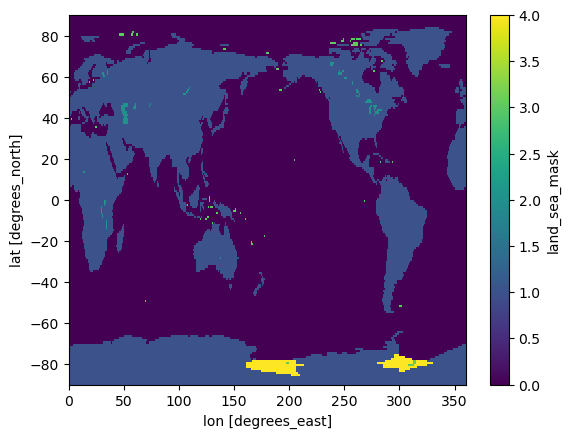

In [2]:
# Open the base grid which to manipulate.
landsea=xr.open_dataset('/home/ucfaccb/miniconda3/envs/ncl/lib/ncarg/data/cdf/landsea.nc')
landsea.LSMASK.plot()
landsea

<xarray.DataArray 'mask' (lat: 180, lon: 360)>
array([[44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5


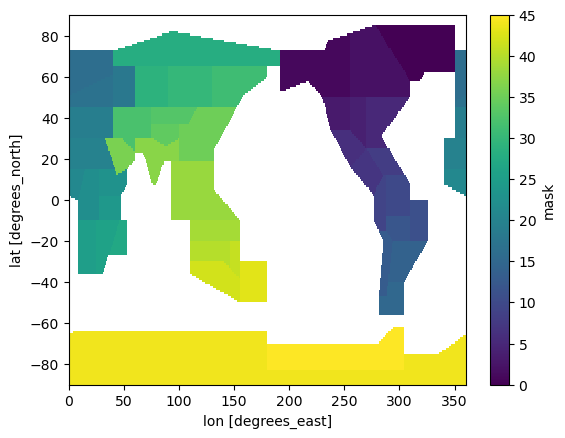

In [9]:
land_masks=regionmask.defined_regions.ar6.land.mask(landsea.lon, landsea.lat)
print(land_masks)
land_masks.plot()

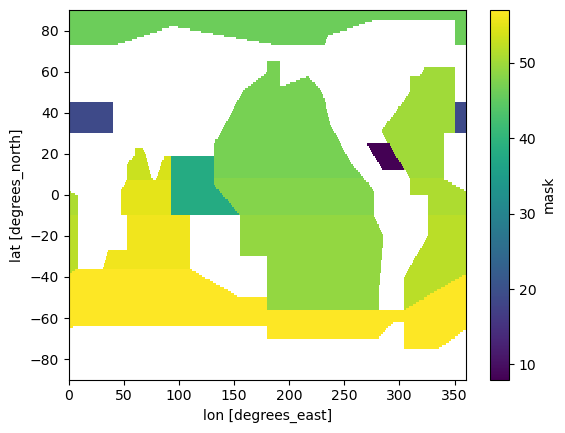

In [3]:
ocean_masks=regionmask.defined_regions.ar6.ocean.mask(landsea.lon, landsea.lat)
ocean_masks.plot()

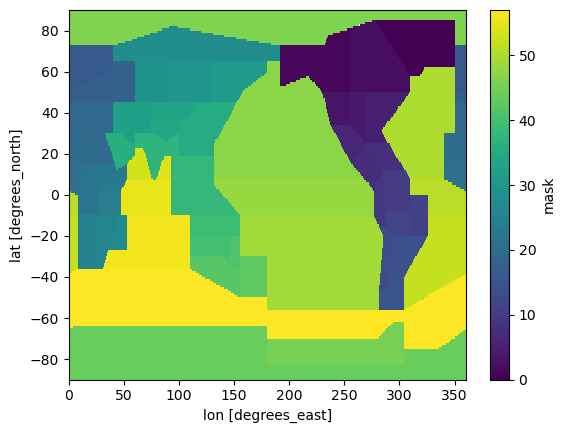

In [4]:
all_masks=regionmask.defined_regions.ar6.all.mask(landsea.lon, landsea.lat)
all_masks.plot()

In [5]:
AR6_masks=landsea.LSMASK.copy()
AR6_masks.data=np.int8(regionmask.defined_regions.ar6.all.mask(landsea.lon, landsea.lat))
# Correct spelling of Indian Ocean
region_names=regionmask.defined_regions.ar6.all.names
region_names[55]="Equatorial.Indian-Ocean"
region_names[56]="S.Indian-Ocean"
AR6_masks=AR6_masks.assign_attrs(number=regionmask.defined_regions.ar6.all.numbers,abbrevs=regionmask.defined_regions.ar6.all.abbrevs,region_names=region_names)
AR6_masks=AR6_masks.assign_attrs(long_name="AR6 Regions",NUMBER=np.int8(regionmask.defined_regions.ar6.all.numbers),description="A combined mask to show the regions delineated by Iturbide et la (2020; Earth Syst. Sci. Data)")
AR6_masks

<xarray.DataArray 'LSMASK' (lat: 180, lon: 360)>
array([[44, 44, 44, ..., 44, 44, 44],
       [44, 44, 44, ..., 44, 44, 44],
       [44, 44, 44, ..., 44, 44, 44],
       ...,
       [46, 46, 46, ..., 46, 46, 46],
       [46, 46, 46, ..., 46, 46, 46],
       [46, 46, 46, ..., 46, 46, 46]], dtype=int8)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    long_name:     AR6 Regions
    number:        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...
    abbrevs:       ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', '...
    region_names:  ['Greenland/Iceland', 'N.W.North-America', 'N.E.North-Amer...
    NUMBER:        [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 ...
    description:   A combined mask to show the regions delineated by Iturbide...

In [6]:
# Add in some additional information to the file
number=regionmask.defined_regions.ar6.all.numbers
LAND=xr.DataArray(np.zeros(58,dtype=np.int8),dims="number")
LAND[0:46]=1
LAND=LAND.assign_attrs(long_name="Region defined over land")
OCEAN=xr.DataArray(np.zeros(58,dtype=np.int8),dims="number")
OCEAN[46:]=1
OCEAN=OCEAN.assign_attrs(long_name="Region defined over ocean")
BOTH=xr.DataArray(np.zeros(58,dtype=np.int8),dims="number")
BOTH=BOTH.assign_attrs(long_name="Region defined over both land and ocean")
MULTIPLY_DEF=xr.DataArray(np.zeros(58,dtype=np.int8),dims="number")
MULTIPLY_DEF[8]=1 # Caribbean
MULTIPLY_DEF[19]=1 # Mediterranean
MULTIPLY_DEF[38]=1 # S.E.Asia
MULTIPLY_DEF=MULTIPLY_DEF.assign_attrs(long_name="Is the region multiply defined (e.g. over both land and ocean)")
MULTIPLY_DEF


<xarray.DataArray (number: 58)>
array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)
Dimensions without coordinates: number
Attributes:
    long_name:  Is the region multiply defined (e.g. over both land and ocean)

In [7]:
AR6_masks_1x1 = xr.Dataset()
AR6_masks_1x1["AR6_masks"]=AR6_masks
AR6_masks_1x1["LAND"]=LAND
AR6_masks_1x1["OCEAN"]=OCEAN
AR6_masks_1x1["BOTH"]=BOTH
AR6_masks_1x1["MULTIPLY_DEF"]=MULTIPLY_DEF
AR6_masks_1x1


<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360, number: 58)
Coordinates:
  * lat           (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: number
Data variables:
    AR6_masks     (lat, lon) int8 44 44 44 44 44 44 44 ... 46 46 46 46 46 46 46
    LAND          (number) int8 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0
    OCEAN         (number) int8 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
    BOTH          (number) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    MULTIPLY_DEF  (number) int8 0 0 0 0 0 0 0 0 1 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

# Now add in some Monsoon Regions
Taken from Figure AV.1 of the Annex V of the IPCC: [https://www.ipcc.ch/report/ar6/wg1/downloads/report/IPCC_AR6_WGI_AnnexV.pdf]

This defines 7 regions of which five monsoon regions. SAfri and EqAmeri are not official monsoons (they are regions of seasonal precipitation instead), but I might as well compute them

['NAmerM', 'EqAmer', 'SAmerM', 'WAfriM', 'SAfri', 'SAsiaM', 'EAsiaM', 'AusMCM']


<xarray.DataArray 'LSMASK' (lat: 180, lon: 360)>
array([[9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       ...,
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9]], dtype=int8)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    long_name:  land_sea_mask

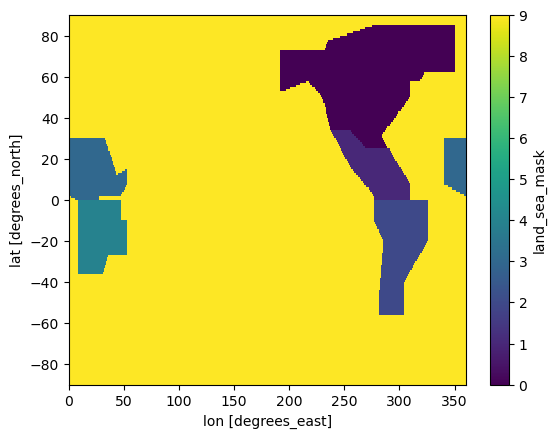

In [27]:
# Define the easy ones first...
AR6_monsoons=landsea.LSMASK.copy()
AR6_monsoons.data=np.full((180, 360), 9, dtype=np.int8) #set up a base array
monsoon_abbrevs=["NAmerM","EqAmer","SAmerM","WAfriM","SAfri","SAsiaM","EAsiaM","AusMCM"]
monsoon_names=["N. American Monsoon","Equatorial America","South American Monsoon","West African Monsoon","southern African","South and South East Asian Monsoon","East Asian Monsoon","Australian-Maritime Continent Monsoon"]
AR6_monsoons.data= np.where((landsea.lat < 0) & (regionmask.defined_regions.ar6.land.mask(landsea.lon, landsea.lat) < 16), 2, AR6_monsoons.data) # South America
AR6_monsoons.data= np.where((landsea.lat > 0) & (regionmask.defined_regions.ar6.land.mask(landsea.lon, landsea.lat) < 11), 1, AR6_monsoons.data) # Equatorial America
AR6_monsoons.data= np.where(regionmask.defined_regions.ar6.land.mask(landsea.lon, landsea.lat) < 6, 0, AR6_monsoons.data) # North America
AR6_monsoons.data= np.where((landsea.lat > 0) & (regionmask.defined_regions.ar6.land.mask(landsea.lon, landsea.lat) > 19) & (regionmask.defined_regions.ar6.land.mask(landsea.lon, landsea.lat) < 24), 3, AR6_monsoons.data) # West Africa
AR6_monsoons.data= np.where((landsea.lat < 0) & (regionmask.defined_regions.ar6.land.mask(landsea.lon, landsea.lat) > 19) & (regionmask.defined_regions.ar6.land.mask(landsea.lon, landsea.lat) < 28), 4, AR6_monsoons.data) # southern Africa
AR6_monsoons.plot()
print(monsoon_abbrevs)
AR6_monsoons


In [ ]:
#Next we need to open monsoon.geojson (from https://github.com/IPCC-WG1/Atlas/blob/main/reference-regions/monsoons.geojson) and start applying that to the split between the Asian monsoons.


In [9]:
# Write this out to file...
AR6_masks_1x1.to_netcdf("AR6_masks_1x1.nc")